<a href="https://colab.research.google.com/github/arigqt/challenge_ens/blob/main/Ari_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
from pathlib import Path

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
import cv2

from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torch.utils.data import Dataset, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Grayscale

# Setup

First, you need to access the data from this colab.

A way to do this is to add the following shared drive to your google drive:
https://drive.google.com/drive/folders/1AfBKbAmrMTLLH33441c5RSlwLp3ePhVT?usp=share_link


In order to do this, just rick-click on the drive and click "Add a shortcut to my Drive"

You also have to connect your google drive to google colab.

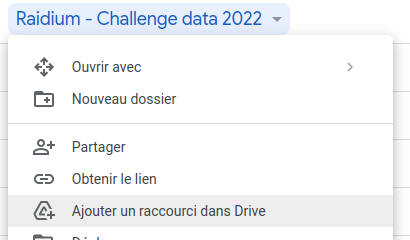

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_dir = Path("/content/gdrive/MyDrive/Raidium - Challenge data 2022/")
labels_train = pd.read_csv(data_dir  / "Y_train.csv", index_col=0).T

In [5]:
def load_dataset(dataset_dir):
    dataset_list = []
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [6]:
data_train = load_dataset(data_dir / "X_train")
data_test = load_dataset(data_dir / "X_test")

In [7]:
def get_trainloader(data_train, labels_train, batch_size=32):
  data_val = data_train[:200].astype('float32')
  labels_val = np.array(labels_train.iloc[:200]).reshape(200, 512, 512).astype('long')
  train_ds = TensorDataset(torch.from_numpy(data_val).unsqueeze(1), torch.from_numpy(labels_val))
  return torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size)

In [8]:
trainloader = get_trainloader(data_train, labels_train, batch_size = 32)

In [37]:
greyscale_transform = transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1) if x.size(1)==1 else x)
inputs, outputs = next(iter(trainloader))
inputs = greyscale_transform(inputs)
inputs.shape

torch.Size([32, 3, 512, 512])

In [22]:
nb_classes = len(np.unique(np.array(labels_train.iloc[:200]).reshape(200, 512, 512)))

In [ ]:
labels_train.sum(axis=1)[198:202]

198.png    3414072
199.png    2916737
200.png          0
201.png          0
dtype: int64

In [26]:
class Block(nn.Module):
    def __init__(self, in_filters, out_filters):
        
        super(Block, self).__init__()
            
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1)
    
        self.batchnorm1 = nn.BatchNorm2d(out_filters)
        self.batchnorm2 = nn.BatchNorm2d(out_filters)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):
        
        x = self.batchnorm1(self.conv1(x)).clamp(0)
        x = self.relu1(x)
        x = self.dropout1(x)
 
        x = self.batchnorm2(self.conv2(x)).clamp(0)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        return x

        
class Unet(nn.Module):

    def __init__(self, k, in_channels, filters):

        super(Unet, self).__init__()
        
        self.enc1 = Block(in_channels, filters)
        self.enc2 = Block(filters, 2*filters)
        self.enc3 = Block(2*filters, 4*filters)
        
# ---- We define the transpose convolution, that does up pooling 2x2 (inverse of maxpooling)

        self.up1 = nn.ConvTranspose2d(4*filters, 2*filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1 = Block(4*filters, 2*filters)
        self.up2 = nn.ConvTranspose2d(2*filters, filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = Block(2*filters, filters)
        
        self.output = nn.Conv2d(filters, k, kernel_size=(1, 1))

    def forward(self, x):

# ---- We define the down sampling phase : block/max pooling

        enc1 = self.enc1(x)
        maxpool1 = F.max_pool2d(enc1, (2, 2))   
        enc2 = self.enc2(maxpool1)
        maxpool2 = F.max_pool2d(enc2, (2, 2))    
        enc3 = self.enc3(maxpool2)  
        
# ---- We define the up sampling phase : transposed convolution(= up pooling)/block
# ---- We define the skip connections

        up1 = torch.cat([enc2, self.up1(enc3)], 1) # skip connection : concatenate previous layer output + enc4 output
        dec1 = self.dec1(up1)   
        up2 = torch.cat([enc1, self.up2(dec1)], 1)
        dec2 = self.dec2(up2)   
     
        output = self.output(dec2)
            
        return output

In [ ]:
class Block(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(out_filters)
        self.relu1  = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.batchnorm1(self.conv1(x)).clamp(0)
        x = self.relu1(x)
        x = self.dropout1(x)
 
        # x = self.batchnorm2(self.conv2(x)).clamp(0)
        # x = self.relu2(x)
        # x = self.dropout2(x)
        return x

class Unet(nn.Module):

    def __init__(self, k, in_channels, filters):

        super(Unet, self).__init__()
        
        self.enc1 = Block(in_channels, filters)
        self.enc2 = Block(filters, 2*filters)
        # self.enc3 = Block(2*filters, 4*filters)
        
# ---- We define the transpose convolution, that does up pooling 2x2 (inverse of maxpooling)

        # self.up1 = nn.ConvTranspose2d(4*filters, 2*filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.dec1 = Block(4*filters, 2*filters)
        self.up2 = nn.ConvTranspose2d(2*filters, filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = Block(2*filters, filters)
        
        self.output = nn.Conv2d(filters, k, kernel_size=(1, 1))

    def forward(self, x):

# ---- We define the down sampling phase : block/max pooling

        enc1 = self.enc1(x)
        maxpool1 = F.max_pool2d(enc1, (2, 2))   
        enc2 = self.enc2(maxpool1)
        maxpool2 = F.max_pool2d(enc2, (2, 2))    
        enc3 = self.enc3(maxpool2)  
        
# ---- We define the up sampling phase : transposed convolution(= up pooling)/block
# ---- We define the skip connections

        up1 = torch.cat([enc2, self.up1(enc3)], 1) # skip connection : concatenate previous layer output + enc4 output
        dec1 = self.dec1(up1)   
        up2 = torch.cat([enc1, self.up2(dec2)], 1)
        dec2 = self.dec2(up2)   
     
        output = self.output(dec2)
            
        return output

In [ ]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision import transforms



In [ ]:
# raise an error because all are not the same device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# inputs, labels = inputs.to(device), labels.to(device)


In [28]:
Unet_model = Unet(k=10, in_channels=1, filters=64)
# Unet_model = fcn_resnet50(weights=None)
Unet_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Unet_model.parameters(), lr=1e-5, weight_decay=1e-8, foreach=True)
summary(Unet_model, (1, 512, 512), 16)

In [38]:
# greyscale_transform = Grayscale(num_output_channels=3)

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        inputs = greyscale_transform(inputs)
        # outputs = greyscale_transform(outputs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Unet_model(inputs)
        loss = criterion(outputs, labels)
        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

OutOfMemoryError: ignored

In [ ]:
import torchvision

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a

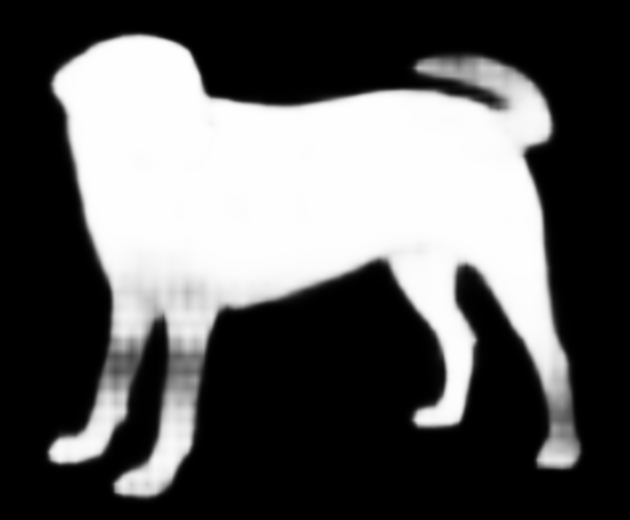

In [ ]:
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image

# img = read_image("gallery/assets/dog1.jpg")
img = read_image("/content/gdrive/MyDrive/dog.jpg")

# Step 1: Initialize model with the best available weights
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and visualize the prediction
prediction = model(batch)["out"]
normalized_masks = prediction.softmax(dim=1)
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
mask = normalized_masks[0, class_to_idx["dog"]]
to_pil_image(mask).show()

In [9]:
import torch.nn as nn
import torch


class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.
    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.
    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.
    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.
    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.
    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.
    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    """Generate the ENet model.
    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.
    """

    def __init__(self, num_classes, encoder_relu=False, decoder_relu=True):
        super().__init__()

        self.initial_block = InitialBlock(3, 16, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 - Encoder
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0, output_size=stage2_input_size)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0, output_size=stage1_input_size)
        x = self.regular5_1(x)
        x = self.transposed_conv(x, output_size=input_size)

        return x

In [23]:
Unet_model = ENet(nb_classes)

# Unet_model = fcn_resnet50(weights=None)
Unet_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Unet_model.parameters(), lr=1e-5, weight_decay=1e-8, foreach=True)
summary(Unet_model, (3, 512, 512), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 13, 256, 256]             351
         MaxPool2d-2          [16, 3, 256, 256]               0
       BatchNorm2d-3         [16, 16, 256, 256]              32
             PReLU-4         [16, 16, 256, 256]               1
      InitialBlock-5         [16, 16, 256, 256]               0
         MaxPool2d-6  [[-1, 16, 128, 128], [-1, 16, 128, 128]]               0
            Conv2d-7          [16, 4, 128, 128]             256
       BatchNorm2d-8          [16, 4, 128, 128]               8
             PReLU-9          [16, 4, 128, 128]               1
           Conv2d-10          [16, 4, 128, 128]             144
      BatchNorm2d-11          [16, 4, 128, 128]               8
            PReLU-12          [16, 4, 128, 128]               1
           Conv2d-13         [16, 64, 128, 128]             256
      BatchNorm2d-14    